In [2]:
import sys
sys.path.append('..')
from utilities.backtesting import get_n_columns
from utilities.get_data import get_historical_from_db
from statistics import mean
import pandas as pd
import numpy as np
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
import matplotlib.markers as markers
from datetime import timedelta
import ta
from IPython.display import clear_output
import ccxt

In [3]:
def get_data_from_api(
    pair_symbol,
    startDate = "2021"
):
    pair = pair_symbol
    tf = "1d"

    df = get_historical_from_db(ccxt.binance(),pair,tf,path="../database/")
    return df.loc[startDate:]

def get_top_and_bottom(df, candle_min_window=3):
    originals_columns = list(df.columns.copy())
    originals_columns.append("top")
    originals_columns.append("bottom")
    dt = df.copy()
    dt["bottom"] = 1
    dt["top"] = 1

    for i in range(1, candle_min_window + 1, 1):
        dt = get_n_columns(dt, ['close'], i)
        dt = get_n_columns(dt, ['close'], -i)

        dt.loc[
            (dt["n" + str(-i) + "_close"] < dt["close"]) 
            | (dt["n" + str(i) + "_close"] < dt["close"])
            , "bottom"
        ] = 0

        dt.loc[
            (dt["n" + str(-i) + "_close"] > dt["close"]) 
            | (dt["n" + str(i) + "_close"] > dt["close"])
            , "top"
        ] = 0
    # print(dt)
    dt = dt.loc[:,originals_columns]

    return dt

def group_level(df, group_multiplier = 1):
    df_test = df.copy()
    d = list(df_test.loc[df_test["bottom"]==1, "close"])
    d.extend(list(df_test.loc[df_test["top"]==1, "close"]))

    d.sort()

    diff = [y - x for x, y in zip(*[iter(d)] * 2)]
    avg = sum(diff) / len(diff)

    important_levels = [[d[0]]]

    for x in d[1:]:
        if x - important_levels[-1][0] < group_multiplier * avg:
            important_levels[-1].append(x)
        else:
            important_levels.append([x])

    return important_levels

def plot_level(
    pair_symbol = "BTC/USDT", 
    startDate = "2021", 
    top_bottom_window = 3, 
    group_multiplier = 1, 
    min_group_number = 2,
    show_tv_code = False
):
    df = get_data_from_api(pair_symbol, startDate)
    df = get_top_and_bottom(df, top_bottom_window)
    levels = group_level(df, group_multiplier)
    
    tv_paste_text = ""

    df["iloc_val"] = list(range(0,len(df),1))
    s = mpf.make_mpf_style(base_mpf_style='charles', rc={'font.size': 6})

    fig1 = mpf.figure(1, figsize=(20, 7), style=s) 
    fig2 = mpf.figure(2, figsize=(20, 7), style=s) 
    ax1 = fig1.add_subplot(111)
    ax2 = fig2.add_subplot(111)


    mpf.plot(df, type='candle', ax=ax1)
    mpf.plot(df, type='candle', ax=ax2)

    plt.figure(1)
    if levels:
        for i in range(len(levels)):
            if len(levels[i]) >= min_group_number:
                plt.hlines(mean(levels[i]), xmin=0, xmax=len(df), colors='blue', lw=len(levels[i]) - (min_group_number - 1))
                tv_paste_text += "\narray.push(levels, " + str(mean(levels[i])) + ")\narray.push(level_width, " + str(len(levels[i]) - (min_group_number - 1)) + ")"

    plt.figure(2)
    for index, row in df.loc[df["top"]==1].iterrows():
        plt.hlines(row["close"],xmin=row["iloc_val"], xmax=len(df), colors='indianred', lw=1)

    for index, row in df.loc[df["bottom"]==1].iterrows():
        plt.hlines(row["close"],xmin=row["iloc_val"], xmax=len(df), colors='purple', lw=1)

    if show_tv_code:
        print(tv_paste_text)

def plot_double_top(df, index_top1, index_top2, mean_price, top_bottom_reader, top_or_bottom=0, hours_multiplier=1):
    if top_or_bottom == 0: 
        color_line = "green"
        marker_sign = "^"
        marker_multiplier = -0.66
    else: 
        color_line = "red"
        marker_sign = "v"
        marker_multiplier = 0.66
    s = mpf.make_mpf_style(base_mpf_style='default', rc={'font.size': 6})
    fig1 = mpf.figure(1, figsize=(20, 7), style=s) 
    ax1 = fig1.add_subplot(111)
    df_plot = df.copy().loc[df.index[index_top1] + timedelta(hours = -10*hours_multiplier):df.index[index_top2] + timedelta(hours = +48*hours_multiplier)]
    mpf.plot(df_plot, type='candle', ax=ax1)
    plt.figure(1)
    plt.hlines(df.iloc[index_top1]["close"], xmin=10, xmax=len(df_plot)-48, colors='orange', lw=2)
    plt.hlines(df.iloc[index_top2+top_bottom_reader]["close"], xmin=len(df_plot)-49+top_bottom_reader, xmax=len(df_plot), colors=color_line, lw=2, zorder=1)
    # plt.scatter(len(df_plot)-49+top_bottom_reader, df.iloc[index_top2+top_bottom_reader]["close"], s=200, marker=">", c=color_line, zorder=2)
    plt.scatter(10, df.iloc[index_top1]["close"] + marker_multiplier * mean_price, s=200, marker=marker_sign, c='orange', zorder=2)
    plt.scatter(len(df_plot)-48, df.iloc[index_top2]["close"] + marker_multiplier * mean_price, s=200, marker=marker_sign, c='orange', zorder=2)
    plt.show()

def double_top_bottom(df, top_bottom_reader=2, plot=False, hours_multiplier=1):
    df["vol"] = abs(df["close"] - df["open"]).rolling(20).mean()
    df["min_close"] = df["close"].rolling(10).min()
    df["max_close"] = df["close"].rolling(10).max()
    df["iloc"] = range(len(df))
    top_data = []
    bottom_data = []

    df = get_top_and_bottom(df, top_bottom_reader)
    df_top_bottom = df.loc[(df["top"] == 1) | (df["bottom"] == 1)]
    # df_top_bottom = df_top_bottom.loc["2022-02"]
    index_list = list(df_top_bottom.index)
    len_df = len(df_top_bottom)
    for i in range(len_df - 2):
        if df_top_bottom.iloc[i]["top"] == 1 and df_top_bottom.iloc[i]["close"] >= df_top_bottom.iloc[i]["max_close"]:
            j = i
            bottom_pass = False
            while df_top_bottom.iloc[i]["close"] > df_top_bottom.iloc[j]["close"] - 0.1 * df_top_bottom.iloc[j]["vol"]:
                
                if j < len_df - 1:
                    j += 1
                else: break
                if df_top_bottom.iloc[j]["top"] != 1:
                    if df_top_bottom.iloc[i]["close"] - df_top_bottom.iloc[j]["close"] > 3*df_top_bottom.iloc[i]["vol"]:
                        bottom_pass = True
                    continue
                if j - i > 20:
                    break
                    
                if (abs(df_top_bottom.iloc[i]["close"] - df_top_bottom.iloc[j]["close"]) < 0.1 * df_top_bottom.iloc[j]["vol"]) and bottom_pass:
                    # print("Double Top:",index_list[i],"->",index_list[j])
                    iloc_j = int(df_top_bottom.iloc[j]["iloc"])
                    price_detected = df.iloc[iloc_j+top_bottom_reader]["close"]
                    
                    top_data.append({
                        "top1": index_list[i],
                        "top2": index_list[j],
                        "price_when_detected": price_detected,
                        "diff_mean_close_3": (df.iloc[iloc_j+top_bottom_reader+1:iloc_j+top_bottom_reader+4]["close"].mean() - price_detected) / price_detected,
                        "diff_mean_close_5": (df.iloc[iloc_j+top_bottom_reader+1:iloc_j+top_bottom_reader+6]["close"].mean() - price_detected) / price_detected,
                        "diff_mean_close_10": (df.iloc[iloc_j+top_bottom_reader+1:iloc_j+top_bottom_reader+11]["close"].mean() - price_detected) / price_detected,
                        "diff_mean_close_20": (df.iloc[iloc_j+top_bottom_reader+1:iloc_j+top_bottom_reader+21]["close"].mean() - price_detected) / price_detected,
                        "diff_mean_close_40": (df.iloc[iloc_j+top_bottom_reader+1:iloc_j+top_bottom_reader+41]["close"].mean() - price_detected) / price_detected,
                    })
                    if plot:
                        plot_double_top(df, int(df_top_bottom.iloc[i]["iloc"]), int(df_top_bottom.iloc[j]["iloc"]), df_top_bottom.iloc[j]["vol"], top_bottom_reader, top_or_bottom=1, hours_multiplier=hours_multiplier)
                        x = input()
                        if x == "x":
                            raise Exception("Stopped")
                        else:
                            clear_output(wait=True)
                            break
                    else: break
        elif df_top_bottom.iloc[i]["bottom"] == 1 and df_top_bottom.iloc[i]["close"] <= df_top_bottom.iloc[i]["min_close"]:
            j = i
            top_pass = False
            while df_top_bottom.iloc[i]["close"] < df_top_bottom.iloc[j]["close"] + 0.1 * df_top_bottom.iloc[j]["vol"]:
                if j < len_df - 1:
                    j += 1
                else: break
                if df_top_bottom.iloc[j]["bottom"] != 1:
                    if df_top_bottom.iloc[j]["close"] - df_top_bottom.iloc[i]["close"] > 3*df_top_bottom.iloc[i]["vol"]:
                        top_pass = True
                    continue
                if j - i > 20:
                    break
                if (abs(df_top_bottom.iloc[i]["close"] - df_top_bottom.iloc[j]["close"]) < 0.1 * df_top_bottom.iloc[j]["vol"]) and top_pass:
                    # print("Double Bottom:",index_list[i],"->",index_list[j])
                    iloc_j = int(df_top_bottom.iloc[j]["iloc"])
                    price_detected = df.iloc[iloc_j+top_bottom_reader]["close"]
                    
                    bottom_data.append({
                        "top1": index_list[i],
                        "top2": index_list[j],
                        "price_when_detected": price_detected,
                        "diff_mean_close_3": (df.iloc[iloc_j+top_bottom_reader+1:iloc_j+top_bottom_reader+4]["close"].mean() - price_detected) / price_detected,
                        "diff_mean_close_5": (df.iloc[iloc_j+top_bottom_reader+1:iloc_j+top_bottom_reader+6]["close"].mean() - price_detected) / price_detected,
                        "diff_mean_close_10": (df.iloc[iloc_j+top_bottom_reader+1:iloc_j+top_bottom_reader+11]["close"].mean() - price_detected) / price_detected,
                        "diff_mean_close_20": (df.iloc[iloc_j+top_bottom_reader+1:iloc_j+top_bottom_reader+21]["close"].mean() - price_detected) / price_detected,
                        "diff_mean_close_40": (df.iloc[iloc_j+top_bottom_reader+1:iloc_j+top_bottom_reader+41]["close"].mean() - price_detected) / price_detected,
                    })
                    if plot:
                        plot_double_top(df, int(df_top_bottom.iloc[i]["iloc"]), int(df_top_bottom.iloc[j]["iloc"]), df_top_bottom.iloc[j]["vol"], top_bottom_reader, top_or_bottom=0, hours_multiplier=hours_multiplier)
                        x = input()
                        if x == "x":
                            raise Exception("Stopped")
                        else:
                            clear_output(wait=True)
                            break
                    else: break
                    
    df_top = pd.DataFrame(top_data)
    len_top = len(df_top)
    print("---",len_top,"Double Top detected")
    print("Average evolution after 3 periods:",round(df_top["diff_mean_close_3"].mean()*100,2),"% |", round(100 * len(df_top.loc[df_top["diff_mean_close_3"] < 0]) / len_top,2),"% win rate")
    print("Average evolution after 5 periods:",round(df_top["diff_mean_close_5"].mean()*100,2),"% |", round(100 * len(df_top.loc[df_top["diff_mean_close_5"] < 0]) / len_top,2),"% win rate")
    print("Average evolution after 10 periods:",round(df_top["diff_mean_close_10"].mean()*100,2),"% |", round(100 * len(df_top.loc[df_top["diff_mean_close_10"] < 0]) / len_top,2),"% win rate")
    print("Average evolution after 20 periods:",round(df_top["diff_mean_close_20"].mean()*100,2),"% |", round(100 * len(df_top.loc[df_top["diff_mean_close_20"] < 0]) / len_top,2),"% win rate")
    print("Average evolution after 40 periods:",round(df_top["diff_mean_close_40"].mean()*100,2),"% |", round(100 * len(df_top.loc[df_top["diff_mean_close_40"] < 0]) / len_top,2),"% win rate")

    df_bottom = pd.DataFrame(bottom_data)
    len_bottom = len(df_bottom)
    print("---",len_bottom,"Double Bottom detected")
    print("Average evolution after 3 periods:",round(df_bottom["diff_mean_close_3"].mean()*100,2),"% |", round(100 * len(df_bottom.loc[df_bottom["diff_mean_close_3"] > 0]) / len_bottom,2),"% win rate")
    print("Average evolution after 5 periods:",round(df_bottom["diff_mean_close_5"].mean()*100,2),"% |", round(100 * len(df_bottom.loc[df_bottom["diff_mean_close_5"] > 0]) / len_bottom,2),"% win rate")
    print("Average evolution after 10 periods:",round(df_bottom["diff_mean_close_10"].mean()*100,2),"% |", round(100 * len(df_bottom.loc[df_bottom["diff_mean_close_10"] > 0]) / len_bottom,2),"% win rate")
    print("Average evolution after 20 periods:",round(df_bottom["diff_mean_close_20"].mean()*100,2),"% |", round(100 * len(df_bottom.loc[df_bottom["diff_mean_close_20"] > 0]) / len_bottom,2),"% win rate")
    print("Average evolution after 40 periods:",round(df_bottom["diff_mean_close_40"].mean()*100,2),"% |", round(100 * len(df_bottom.loc[df_bottom["diff_mean_close_40"] > 0]) / len_bottom,2),"% win rate")


In [4]:
pair = "BTC/USDT"
tf = "1h"
ex = "binance"
df = get_historical_from_db(ccxt.binance(), pair, tf, path="../database/").loc["2022":]
df
double_top_bottom(df, plot=False)

--- 23 Double Top detected
Average evolution after 3 periods: -0.07 % | 47.83 % win rate
Average evolution after 5 periods: -0.1 % | 52.17 % win rate
Average evolution after 10 periods: 0.06 % | 47.83 % win rate
Average evolution after 20 periods: 0.28 % | 39.13 % win rate
Average evolution after 40 periods: 0.45 % | 52.17 % win rate
--- 12 Double Bottom detected
Average evolution after 3 periods: 0.03 % | 58.33 % win rate
Average evolution after 5 periods: -0.04 % | 66.67 % win rate
Average evolution after 10 periods: -0.18 % | 41.67 % win rate
Average evolution after 20 periods: -0.25 % | 25.0 % win rate
Average evolution after 40 periods: -0.22 % | 25.0 % win rate


c:\ProgramData\Anaconda3\lib\site-packages\mplfinance\_arg_validators.py:83: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


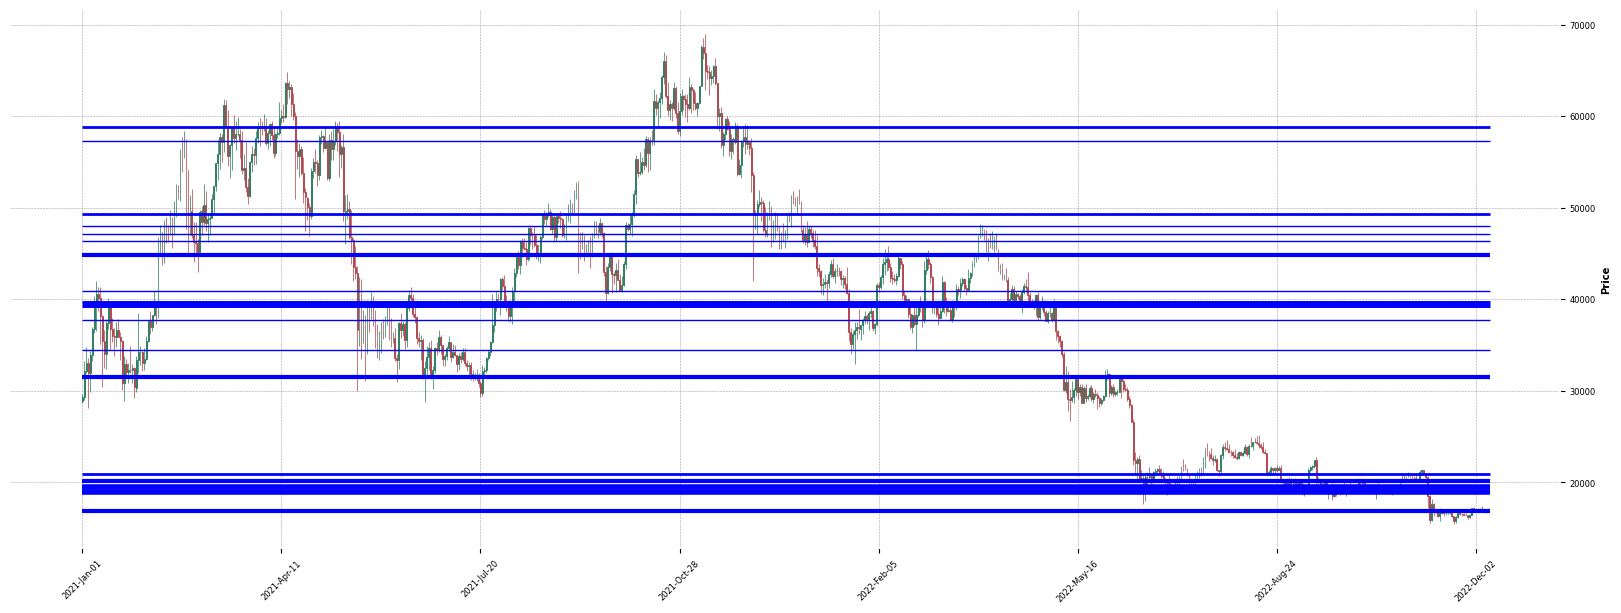

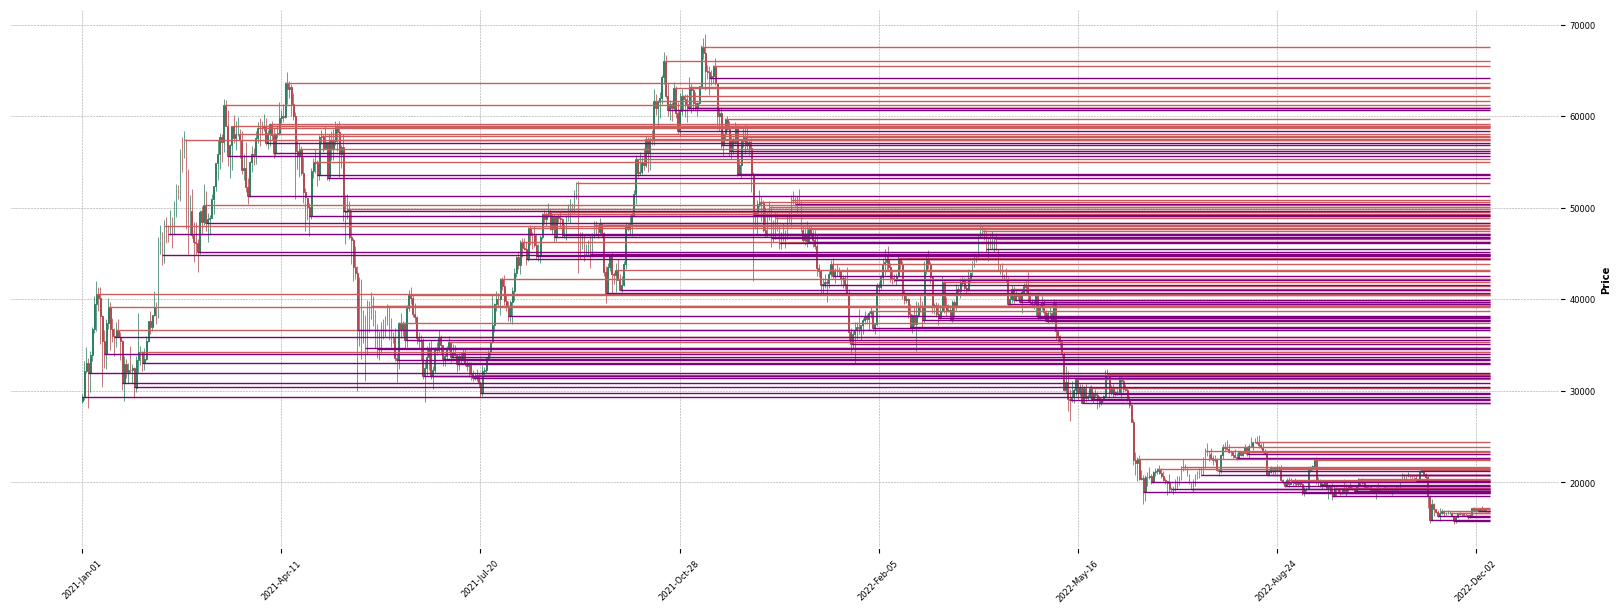

In [5]:
plot_level(
    pair_symbol = "BTC/USDT", 
    startDate = "2021", 
    top_bottom_window = 2, 
    group_multiplier = 2, 
    min_group_number = 5,
    show_tv_code = False
)